# Chapter 5. Monte Carlo
## Example 5.1: Blackjack
구현하려면 문제를 잘 읽어야 겠지요? 천천히 먼저 읽어 보세요. 

문제에서 "Rewards of -1, +1, and 0". 라고 하였으며, $\gamma$=1이고, hit과 stick 에 따른 보상은 0입니다. 즉 승패가 Return이 됩니다. 

### 1. First-visit MC prediction, for estimating V

Fixed Policy(고정 정책?) 임을 유의해서 코드를 읽어 보세요. 고정 정책을 따르며 상태들만 기록하고 마지막 보상 하나를 반환합니다. 

In [ ]:
import random
from collections import defaultdict

# -----------------------------
# 블랙잭 환경 정의
# -----------------------------
def draw_card():
    r = random.randint(1, 13)
    if r == 1:   # Ace
        return 1
    elif 2 <= r <= 10:
        return r
    else:        # J, Q, K
        return 10

def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def hand_value(hand):
    val = sum(hand)
    if 1 in hand and val + 10 <= 21:
        return val + 10
    return val

def is_bust(hand):
    return hand_value(hand) > 21

def policy_fixed(player_sum):
    return 'stick' if player_sum >= 20 else 'hit'

def dealer_policy(dealer_sum):
    return 'stick' if dealer_sum >= 17 else 'hit'

def step_player(player, action):
    if action == 'hit':
        player = player + [draw_card()]
        return player, is_bust(player)
    elif action == 'stick':
        return player, False

def play_dealer(dealer):
    while dealer_policy(hand_value(dealer)) == 'hit':
        dealer += [draw_card()]
    return dealer

def outcome(player, dealer):
    if is_bust(player):
        return -1
    if is_bust(dealer):
        return +1
    p, d = hand_value(player), hand_value(dealer)
    if p > d: return +1
    elif p == d: return 0
    else: return -1

def generate_episode_fixed_policy(): 
    player = [draw_card(), draw_card()] # 플레이어 초기 카드 두 장 받고,
    dealer = [draw_card(), draw_card()] # 딜러 초기 카드 두 장 받고,
    dealer_up = dealer[0] # 딜러는 카드를 공개합니다.

    states = []
    while True:
        p_sum = hand_value(player) # ACE의 정의 방법에 따라 숫자가 달라지기 때문에, 1과 11 중 선택하여 최선의 숫자로 현재 카드 합계 값을 만들어 줍니다. 
        if p_sum < 12: # 무조건 hit 합니다(교과서에서 상태를 정의한 방법으로, 문제 정의에 따라 12 미만은 무조건 hit이 이득입니다).
            player, bust = step_player(player, 'hit')
            if bust: return states, -1  # bust면 망했으니 -1, 
            continue                    # bust가 아니면 다시 처음부터 진행합니다.
        state = (p_sum, dealer_up, usable_ace(player)) # 상태는 셋으로 정의합니다. 현재 내 덱의 카드 합(p_sum), 딜러의 공개 카드(dealer_up), 그리고 내가 ACE를 가지고 있는지 여부(usable_ace)입니다.
        action = policy_fixed(p_sum)    # 교재 예제 정책을 따릅니다. 20 또는 21이면 stick, 그렇지 않으면 hit를 반환합니다.
        states.append(state)            # 이번 의사결정 시점의 상태를 기록합니다. 
        if action == 'stick':           # 정책이 stick을 선택하면 플레이어의 턴을 종료하고, 딜러의 턴으로 넘어갑니다.
            break   
        else:                                           # 정책이 hit인 경우,
            player, bust = step_player(player, 'hit')   # 한장을 더 받습니다. 
            if bust: return states, -1

    dealer = play_dealer(dealer)        # 플레이어가 stick 하여 루프를 빠져나온 경우 실행됩니다. 
    return states, outcome(player, dealer) # outcome은 플레이어와 딜러의 최종 합과 bust 여부를 비교해 승리 +1, 무승부 0, 패배 −1을 돌려줍니다. 반환된 (states, G) 쌍은 First-visit MC 예측에서 각 상태의 리턴을 누적·평균하여 V(s)를 추정하는 데 사용됩니다.

# -----------------------------
# First-visit MC prediction
# -----------------------------
def mc_prediction_first_visit(n_episodes=100000):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    V = defaultdict(float)

    for _ in range(n_episodes):
        states, G = generate_episode_fixed_policy()
        seen = set()
        for s in states:
            if s not in seen:
                seen.add(s)
                returns_sum[s] += G
                returns_count[s] += 1

    for s in returns_sum:
        V[s] = returns_sum[s] / returns_count[s]
    return V

V_fixed = mc_prediction_first_visit(500000)
print("예시: (20, 10, False) 상태의 추정 가치 =", V_fixed[(20, 10, False)])

예시: (20, 10, False) 상태의 추정 가치 = 0.43595310464611375


### 2. Monte Carlo ES (Exploring Starts), for estimating $\pi$

행동하는 방식을 새로 배웠습니다. Exploring start의 의미를 다시 확인해 보세요. 

ES의 핵심 가정은 모든 상태–행동 쌍에서 시작할 기회를 보장하는 것이기 때문에, 에피소드가 임의의 ($s_0$,$a_0$)에서 “시작”할 수 있어야 합니다. 물리적으로 이 상황을 만들어 주는 부분이 필요합니다. 

함수를 mc_control_es 라고 작성하였지만, control은 정책을 개선하는 과정이 포함되어 있다면 control 이라고 이름을 붙입니다. 다음 장에 나오는 On-policy first-visit MC control (for "-soft policies) 와 혼동하지 마세요. 

In [ ]:
ACTIONS = ('hit', 'stick')

def random_state_action():
    p_sum = random.randint(12, 21)
    dealer_show = random.randint(1, 10)
    ua = bool(random.getrandbits(1))
    a = random.choice(ACTIONS)
    return (p_sum, dealer_show, ua), a

def generate_episode_from_state_action(start_state, start_action, Q): # 임의의 위치 s0, a0에서 시작하고, Q를 참고하여 이후 greedy 행동 선택합니다. 기존 알고리즘은 Q가 필요 없고, fixed policy를 따랐지만, 이제는 Q에 따라 행동을 선택합니다.
    target_p_sum, dealer_show, ua = start_state # ua는 usable ace를 말합니다.
    # ES이므로 초기 player/dealer 덱을 강제로 만들어 줍니다. 
    # 아래 방식은 교수가 학생 때 작성한 방식으로 usable ace 를 이용해 초기 덱을 만드는 방법이나, 더 적합한 방식이 많이 있습니다. 구현해 보세요. 
    player = [target_p_sum - 10, 1] if ua else [target_p_sum // 2, target_p_sum - target_p_sum // 2]
    dealer = [dealer_show, draw_card()] # ES를 위해 뒤집은 카드는 지정하고, 가린 카드는 랜덤으로 선택합니다.

    episode = [] # 기존에는 상태들의 리스트와 최종 보상 하나만 반환했지만, 여기서는 나중의 Q 갱신을 위해 각 단계의 (s,a)를 전부 보관합니다.
    s, a = start_state, start_action
    states_actions = [(s, a)]

    # 플레이어 진행 부분입니다. 다 비슷한데, ES에서는 행동 규칙이 달라집니다.
    while True:
        if a == 'hit':
            player, bust = step_player(player, 'hit') # hit 했을 때 bust 확인합니다.
            if bust:
                for (ss, aa) in states_actions:
                    episode.append((ss, aa, -1)) # Bust 했을 때 기존 함수는 -1을 반환했는데, 이제는 (s, a)를 키로 이용하여 Q를 갱신할 수 있도록 반환합니다. 
                return episode
        else:  # stick 선택
            break

        p_sum = hand_value(player)  # hit 했을 때 현재 카드 합을 계산합니다.
        if p_sum < 12:              # 여긴 기존 알고리즘과 동일하고, 
            a = 'hit'
            continue
        s = (p_sum, dealer_show, usable_ace(player)) # 현재 결정 상태를 구성 하는 부분도 동일하고, 
        # 현재 상태에서의 두 행동의 추정 가치 Q(s,hit), Q(s,stick)을 불러옵니다. Q가 아직 없는 상태-행동 쌍에 대해서는 0.0을 기본값으로 사용합니다. 
        # Fixed policy 와 다른 부분입니다. 기존 함수는 정책 함수 하나만 보고 행동을 결정했지만, 여기서는 추정된 Q를 기준으로 행동을 선택합니다.
        q_hit = Q.get((s, 'hit'), 0.0)          
        q_stick = Q.get((s, 'stick'), 0.0)

        # Q에 대해 greedy 행동 선택합니다. "Policy Improvement"에 해당합니다.
        # 기존 알고리즘에서는 개선하지 않고 “20·21에서 stick, 아니면 hit”를 고정적으로 따랐지요?
        a = 'hit' if q_hit >= q_stick else 'stick' 
        
        # 이번 결정의 (s,a)를 기록합니다. 이후 한 번의 최종 보상을 이들 모두에게 귀속시켜 Q를 갱신합니다. 기존 알고리즘에는 행동을 기록하지 않았습니다. 
        states_actions.append((s, a))

        if a == 'stick': break

    dealer = play_dealer(dealer)
    R = outcome(player, dealer)
    for (ss, aa) in states_actions:
        episode.append((ss, aa, R)) # 에피소드 내에서 방문한 모든 상태–행동 쌍에 동일한 최종 보상을 붙여 저장합니다. 이후 MC control의 First-visit 갱신으로 Q(ss,aa)를 업데이트하는 데 쓰입니다. 기존 함수는 상태 리스트와 보상 하나를 반환하여 V(s)만 추정했습니다.
    return episode # “상태–행동–보상” 시퀀스를 반환합니다. control에서는 이 반환값을 이용해 에피소드마다 Q를 갱신하고, 다시 그리디 정책으로 개선하는 과정을 반복합니다. 

def mc_control_es(n_episodes=200000):
    Q, returns_sum, returns_count, policy = defaultdict(float), defaultdict(float), defaultdict(int), {}
    for _ in range(n_episodes):
        s0, a0 = random_state_action()
        episode = generate_episode_from_state_action(s0, a0, Q)
        visited = set()
        for (s, a, G) in episode:
            if (s, a) not in visited:
                visited.add((s, a))
                returns_sum[(s, a)] += G
                returns_count[(s, a)] += 1
                Q[(s, a)] = returns_sum[(s, a)] / returns_count[(s, a)]
        for (s, a, _) in episode:
            q_hit, q_stick = Q.get((s, 'hit'), 0.0), Q.get((s, 'stick'), 0.0)
            policy[s] = 'hit' if q_hit >= q_stick else 'stick'
    return Q, policy

Q_es, policy_es = mc_control_es(500000)
print("예시: (20, 10, False) 상태에서 학습된 정책 =", policy_es[(20, 10, False)])

예시: (20, 10, False) 상태에서 학습된 정책 = stick


### 3. MC Control

Control에 대해서 다루는 챕터입니다. On-policy와 Off-policy가 있었지요? 이 방법이 왜 소개가 되었는지 기억하나요? 

우선 On-policy로 구현해 봅니다. 수업 시간에 소개하는 $\varepsilon$-soft policy의 의미를 코드와 함께 이해해 봅시다. 

이제부터 그림을 그려 볼 거니, off-policy와 곧 비교할거라 편의상 라이브러리를 불러오고, 블랙잭 게임을 구현하는 부분도 다시 합니다. 위에 구현을 했으니 없어도 됩니다. 

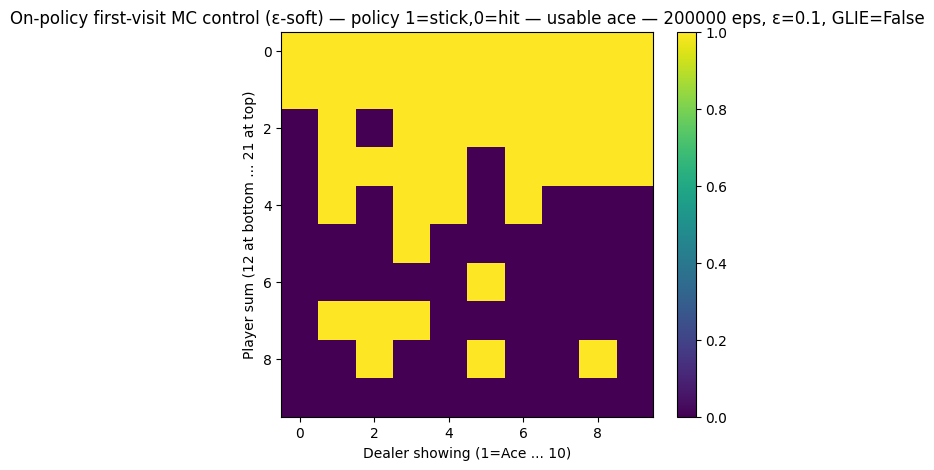

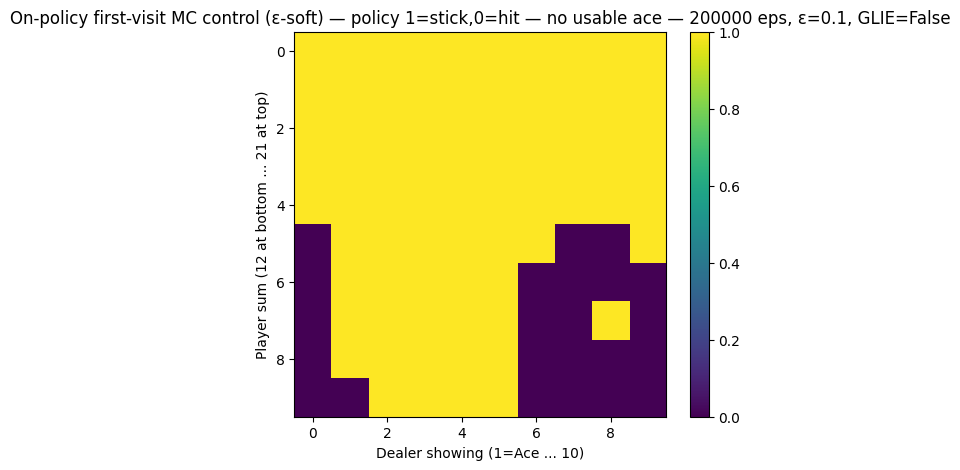

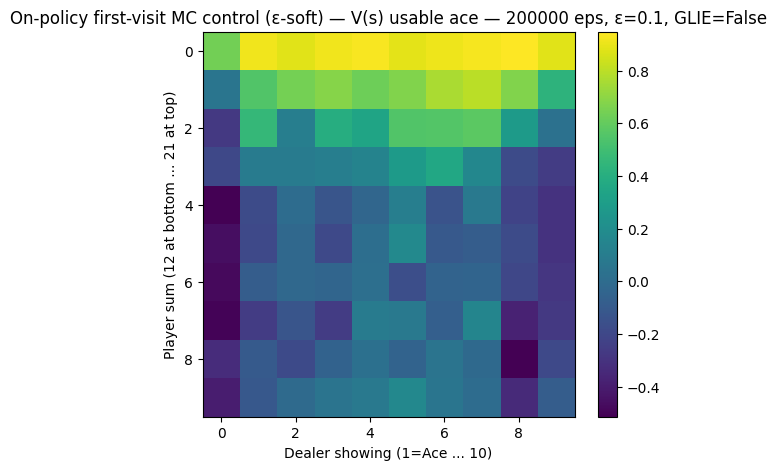

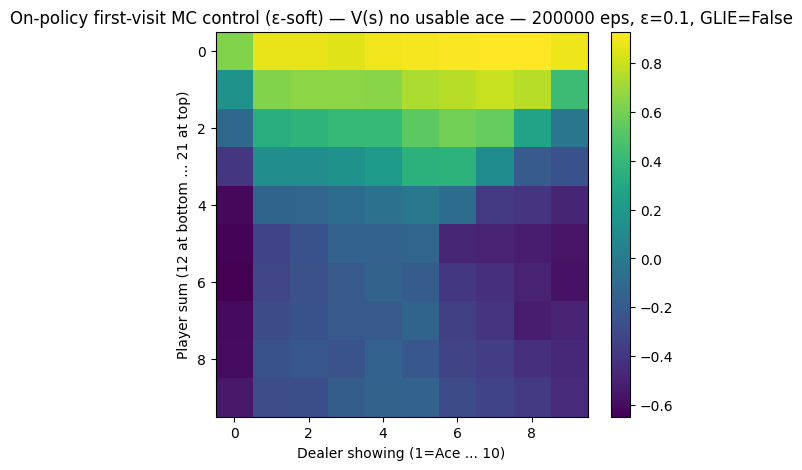

In [ ]:
import random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Blackjack environment
# -----------------------------
def draw_card():
    r = random.randint(1, 13)
    if r == 1:
        return 1                  
    elif 2 <= r <= 10:
        return r
    else:
        return 10                 

def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def hand_value(hand):
    val = sum(hand)
    if 1 in hand and val + 10 <= 21:
        return val + 10
    return val

def is_bust(hand):
    return hand_value(hand) > 21

def dealer_policy(dealer_sum):
    return 'stick' if dealer_sum >= 17 else 'hit'

def step_player(player, action):
    if action == 'hit':
        player = player + [draw_card()]
        return player, is_bust(player)
    elif action == 'stick':
        return player, False
    else:
        raise ValueError("invalid action")

def play_dealer(dealer):
    while dealer_policy(hand_value(dealer)) == 'hit':
        dealer += [draw_card()]
    return dealer

def outcome(player, dealer):
    if is_bust(player):
        return -1
    if is_bust(dealer):
        return +1
    p, d = hand_value(player), hand_value(dealer)
    if p > d: return +1
    if p == d: return 0
    return -1

# -----------------------------
# ε-soft on-policy episode generator
# -----------------------------
ACTIONS = ('hit', 'stick')

def greedy_action_from_Q(Q, s):
    qh = Q.get((s, 'hit'), 0.0)
    qs = Q.get((s, 'stick'), 0.0)
    if qh > qs:
        return 'hit'
    if qs > qh:
        return 'stick'
    return random.choice(ACTIONS)

def epsilon_soft_action(Q, s, epsilon):
    greedy_a = greedy_action_from_Q(Q, s)
    if random.random() < (1.0 - epsilon):
        return greedy_a
    return random.choice(ACTIONS)           # Action은 stick 과 hit 둘이죠? |A|=2 이므로, 수식을 따라가면 각각 ε/2 입니다.

def has_natural(hand):
    return (1 in hand) and (hand_value(hand) == 21)

def generate_episode_onpolicy_eps(Q, epsilon, seed=None):
    if seed is not None:
        random.seed(seed)
    player = [draw_card(), draw_card()]
    dealer = [draw_card(), draw_card()]
    dealer_up = dealer[0]

    if has_natural(player):
        if has_natural(dealer):
            return [], 0
        else:
            return [], +1

    sa_seq = []
    while True:
        p_sum = hand_value(player)
        if p_sum < 12:
            player, bust = step_player(player, 'hit')
            if bust:
                return sa_seq, -1
            continue

        s = (p_sum, dealer_up, usable_ace(player))
        a = epsilon_soft_action(Q, s, epsilon) # ε-soft로 행동을 선택합니다. ES에서 시작을 어떻게 했지요?
        sa_seq.append((s, a))

        if a == 'stick':
            break
        player, bust = step_player(player, 'hit')
        if bust:
            return sa_seq, -1

    dealer = play_dealer(dealer)
    R = outcome(player, dealer)
    return sa_seq, R

# -----------------------------
# On-policy first-visit MC control (ε-soft)
# -----------------------------
def onpolicy_first_visit_mc_control(n_episodes=200000, epsilon=0.1, glie=False, glie_c=50000, seed=7):
    random.seed(seed)
    Q = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    for k in range(1, n_episodes + 1):
        eps_k = max(0.01, glie_c / (glie_c + k)) if glie else epsilon
        sa_seq, G = generate_episode_onpolicy_eps(Q, eps_k)

        visited = set()
        for (s, a) in sa_seq:
            if (s, a) in visited:
                continue
            visited.add((s, a))
            returns_sum[(s, a)] += G
            returns_count[(s, a)] += 1
            Q[(s, a)] = returns_sum[(s, a)] / returns_count[(s, a)]
        # Policy improvement is implicit: subsequent episodes sample ε-soft wrt updated Q
    return Q

# -----------------------------
# Derive V and a deterministic policy for visualization
# -----------------------------
def derive_policy_from_Q(Q):
    policy = {}
    for ps in range(12, 22):
        for ds in range(1, 11):
            for ua in (False, True):
                s = (ps, ds, ua)
                qh = Q.get((s, 'hit'), None)
                qs = Q.get((s, 'stick'), None)
                if qh is None and qs is None:
                    continue
                if (qh or 0.0) >= (qs or 0.0):
                    policy[s] = 'hit'
                else:
                    policy[s] = 'stick'
    return policy

def V_from_Q(Q):
    V = {}
    for (s, a), val in Q.items():
        cur = V.get(s, None)
        if cur is None or val > cur:
            V[s] = val
    return V

# -----------------------------
# Grids and simple heatmaps
# -----------------------------
def grid_policy(policy, usable=True):
    grid = np.full((10, 10), np.nan)
    for ps in range(12, 22):
        for ds in range(1, 11):
            s = (ps, ds, usable)
            if s in policy:
                grid[ps - 12, ds - 1] = 1 if policy[s] == 'stick' else 0
    return grid

def grid_value(V, usable=True):
    grid = np.full((10, 10), np.nan)
    for ps in range(12, 22):
        for ds in range(1, 11):
            s = (ps, ds, usable)
            if s in V:
                grid[ps - 12, ds - 1] = V[s]
    return grid

def show_heatmap(grid, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(np.flipud(grid), aspect='auto')
    plt.title(title)
    plt.xlabel('Dealer showing (1=Ace ... 10)')
    plt.ylabel('Player sum (12 at bottom ... 21 at top)')
    plt.colorbar()
    plt.show()

# -----------------------------
# Train and visualize
# -----------------------------
EPISODES   = 200_000     # increase for smoother surfaces
EPSILON    = 0.1         # fixed ε for ε-soft behavior
USE_GLIE   = False       # set True to use GLIE schedule ε_k = c/(c+k)
GLIE_CONST = 50_000

Q_eps = onpolicy_first_visit_mc_control(n_episodes=EPISODES,
                                        epsilon=EPSILON,
                                        glie=USE_GLIE,
                                        glie_c=GLIE_CONST,
                                        seed=7)
policy_eps = derive_policy_from_Q(Q_eps)
V_eps = V_from_Q(Q_eps)

pol_ua = grid_policy(policy_eps, usable=True)
pol_nua = grid_policy(policy_eps, usable=False)
V_ua = grid_value(V_eps, usable=True)
V_nua = grid_value(V_eps, usable=False)

show_heatmap(pol_ua, f'On-policy first-visit MC control (ε-soft) — policy 1=stick,0=hit — usable ace — {EPISODES} eps, ε={EPSILON}, GLIE={USE_GLIE}')
show_heatmap(pol_nua, f'On-policy first-visit MC control (ε-soft) — policy 1=stick,0=hit — no usable ace — {EPISODES} eps, ε={EPSILON}, GLIE={USE_GLIE}')
show_heatmap(V_ua, f'On-policy first-visit MC control (ε-soft) — V(s) usable ace — {EPISODES} eps, ε={EPSILON}, GLIE={USE_GLIE}')
show_heatmap(V_nua, f'On-policy first-visit MC control (ε-soft) — V(s) no usable ace — {EPISODES} eps, ε={EPSILON}, GLIE={USE_GLIE}')